Initialise the notebook:

In [5]:
%matplotlib inline

import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy.table import Table

import os
import sys
sys.path.append('/Users/amsys/bindata')
import tfpy

from IPython.display import Image

mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80
mpl.rc('text', usetex = True)
mpl.rc('font', family = 'serif')

os.chdir('/Users/amsys/paper_cloudy')

We've done two runs in the Ha range: one with a radius 10x our NGC5548 model.
Comparing the spectra for them:

In [9]:
r10 = 'l100_rad10'
r01 = 'l100_rad01'

/Users/amsys/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


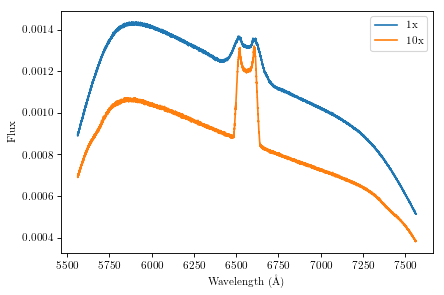

In [3]:
def plot_spec(col, spectra, names, logX=False, logY=False, scale_to=None, limX=False):
    fig, ax = plt.subplots()
    ax.set_xlabel(r"Wavelength (\AA)")
    
    if scale_to:
        ax.set_ylabel(r"$F_{\lambda}/F_{"+str(scale_to)+r"\AA}$")
    else:
        ax.set_ylabel(r"Flux")
        scale_factor = 1
    
    maxY = -1
    minY = 99999999
    
    for spectrum, name in zip(spectra, names):
        if scale_to: 
            # Annoyingly, the file is sorted by frequency not wavelength 
            # so we need to flip it to get searchsorted to run
            index_scale = np.searchsorted(spectrum['Lambda'][::-1], scale_to)
            scale_factor = spectrum[col][::-1][index_scale]
        
        if limX:
            minY_curr = np.amin(spectrum[col][(spectrum['Lambda']>limX[0]) & (spectrum['Lambda']<limX[1])])/scale_factor
            if minY_curr < minY:
                minY = minY_curr
            maxY_curr = np.amax(spectrum[col][(spectrum['Lambda']>limX[0]) & (spectrum['Lambda']<limX[1])])/scale_factor
            if maxY_curr > maxY:
                maxY = maxY_curr
        
        if logX and logY:
            ax.loglog(spectrum['Lambda'], spectrum[col]/scale_factor, label=name)
        elif logY:
            ax.semilogy(spectrum['Lambda'], spectrum[col]/scale_factor, label=name)
        elif logX:
            ax.semilogx(spectrum['Lambda'], spectrum[col]/scale_factor, label=name)
        else:
            ax.plot(spectrum['Lambda'], spectrum[col]/scale_factor, label=name)
            
    if limX:
        ax.set_xlim(limX[0], limX[1])
        ax.set_ylim(minY, maxY)
            
    ax.legend()
    fig.show()
    
spec_r01 = Table.read(r01+'.spec', format='ascii')
spec_r10 = Table.read(r10+'.spec', format='ascii')

plot_spec('A40P0.50', [spec_r01, spec_r10], ['1x', '10x'])

We get a **much** stronger line in the 10x radius model, with a vastly improved line-continuum ratio. The dips at the edge of the spectrum are a feature of our binning in the model; we have no photons generated beyond the <5500/>7500 bounds, so none can be up/down scattered from there into our spectrum.

Plotting the distribution of C-IV and H-I species throughout the wind:

/Users/amsys/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10
/Users/amsys/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


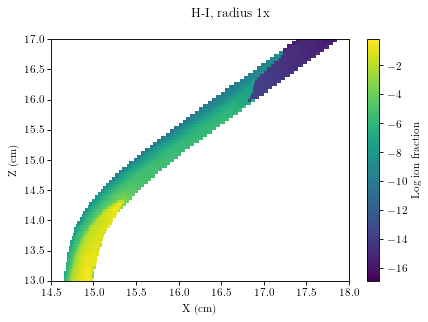

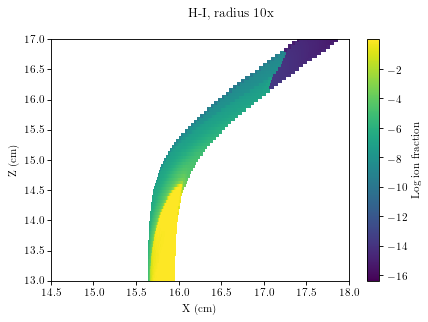

In [186]:
import matplotlib.colors as colors

def load_grid(prefix):
    return [np.loadtxt(prefix+'.grid_x.txt'),
            np.loadtxt(prefix+'.grid_z.txt')]

x_r01, z_r01 = load_grid(r01+'.dom0')
x_r10, z_r10 = load_grid(r10+'.dom')

table_h1_r01 = Table.read(r01+'.ionH1.dat', format='ascii')
table_h1_r10 = Table.read(r10+'.ionH1.dat', format='ascii')

def plot_dat(table, x, z, title):
    fig, ax = plt.subplots() 
    fig.suptitle(title)
    ax.set_xlabel('X (cm)')
    ax.set_ylabel('Z (cm)')
    
    size = (len(x)-1, len(z)-1)
    data = np.reshape(table['var'], size).T
    
    im = ax.pcolormesh(np.log10(x), np.log10(z), np.ma.log10(data))
    ax.set_xlim(14.5, 18)
    ax.set_ylim(13, 17)
    cbar = fig.colorbar(im, ax=ax).set_label('Log ion fraction')
    fig.show()
    
    
plot_dat(table_h1_r01, x_r01, z_r01, 'H-I, radius 1x')
plot_dat(table_h1_r10, x_r10, z_r10, 'H-I, radius 10x')

Neatly, we don't seem to see any change in the extended wind behaviour- everything at or greater than ~1e14.5cm height is more or less equivalent. The transition zone from wind base to extended wind is roughly consistent. We also see a much greater ion fraction of H-1 in the base.

/Users/amsys/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10
/Users/amsys/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


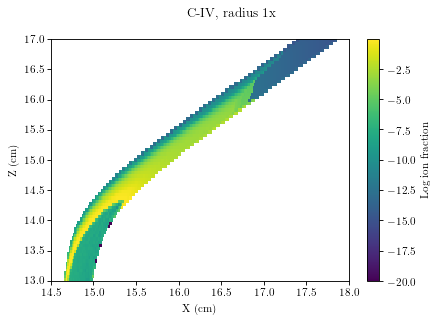

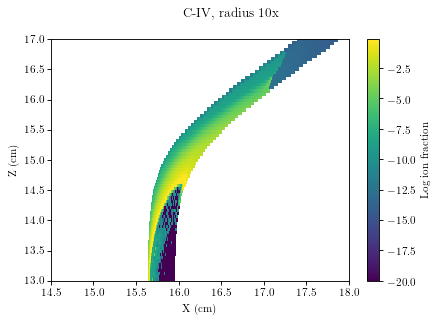

In [187]:
table_c4_r01 = Table.read(r01+'.ionC4.dat', format='ascii')
table_c4_r10 = Table.read(r10+'.ionC4.dat', format='ascii')

plot_dat(table_c4_r01, x_r01, z_r01, 'C-IV, radius 1x')
plot_dat(table_c4_r10, x_r10, z_r10, 'C-IV, radius 10x')

For C-IV, the situation is more or less the same in terms of ion distribution. Emission still occurs at roughly the same height above the disk, just at a later radius, the extended wind region is still roughly similar and peters out at the same radius. There's less C-IV in the base but the front seems sharper to compensate.

Next steps are:
* Do another run with a full spectrum to see if the line-continuum improvements are just a Ha thing and the rest of the spectrum is wrecked, or if it's an all-round good thing
* Bin the Hb photons and verify that we're expecting an OOM increase in path
* Do all this sort of analysis in Jupyter Notebooks stored on GitHub in future so I don't have to root around three different machines for the python & gnuplot scripts used to make figures

We want to compare the full spectra:
    

/Users/amsys/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


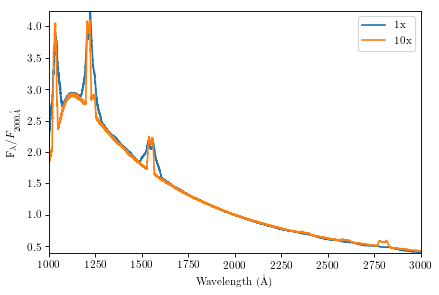

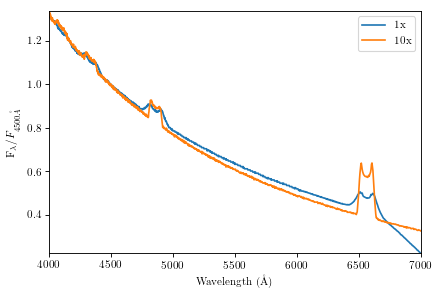

In [191]:
spec_r01_full = Table.read(r01+'_s-full.spec', format='ascii')
spec_r10_full = Table.read(r10+'_s-full.spec', format='ascii')
plot_spec('A40P0.50', [spec_r01_full, spec_r10_full], ['1x', '10x'], limX=(1000, 3000), scale_to=2000)
plot_spec('A40P0.50', [spec_r01_full, spec_r10_full], ['1x', '10x'], limX=(4000, 7000), scale_to=4500)

Looks fairly promising. The lower-wavelength lines aren't quite as boosted by the change as Ha is, but we get an improvement in Hb too. The lines are unsurprisingly narrowed, C-IV being most dramatically so. We want the actual delay too:

Running...
Opening database 'l100_rad10'...
Found existing filled photon database 'l100_rad10'
Opened DB
Created TF
'l100_rad10_plot' successfully run (248.2s)
Plotting to file 'l100_rad10_plot.eps'...
Total line: 5.890e-04
Successfully plotted (1.7s)
Plotted TF
Delay: 2.26701484711303 days
Delay: 195869.64404256313 seconds


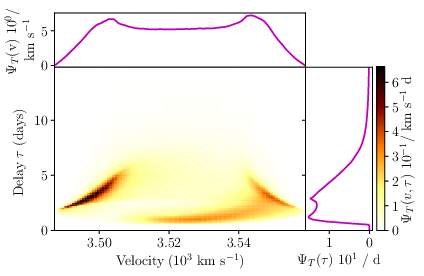

In [10]:
print('Running...')
db = tfpy.open_database(r10)
print('Opened DB')
tf = tfpy.TransferFunction(db, r10+'_plot', continuum=1.043e44, wave_bins=100, delay_bins=100)
print('Created TF')
tf.line(28, 6562.8).delay_dynamic_range(2).run(scaling_factor=1/20).plot(velocity=True)
print('Plotted TF')
print("Delay: {} days".format(tf.delay(threshold=0.8) * 1.15741e-5))
print("Delay: {} seconds".format(tf.delay(threshold=0.8)))    
os.system('convert '+r10+'_plot.eps '+r10+'_plot.png')
Image(filename = r10+'_plot.png', width=800, height=800)

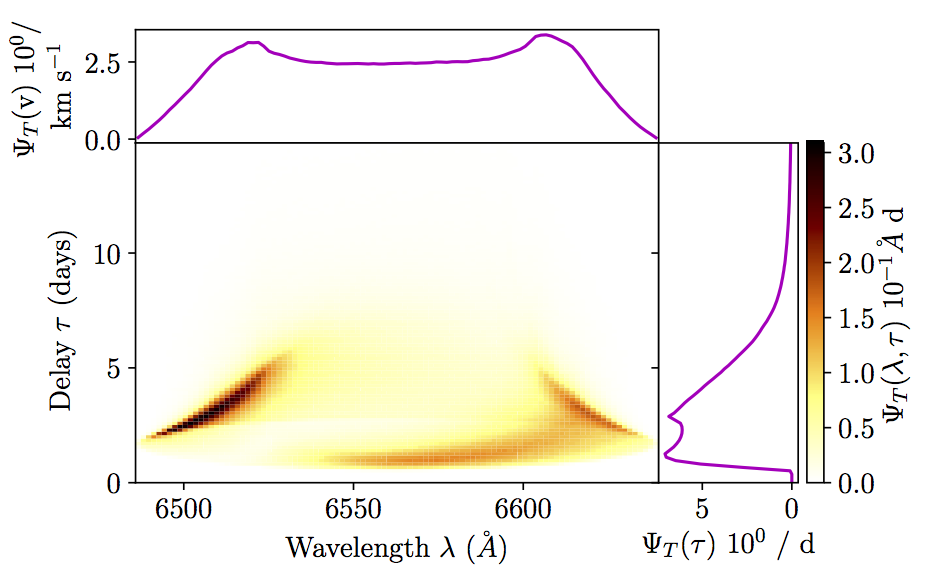

The Hb delay is now , muuuuch closer to the literature value. There's currently a run on to get the  C-IV photons, for binning and comparison to the data. Adding the point to our existing plot gives:

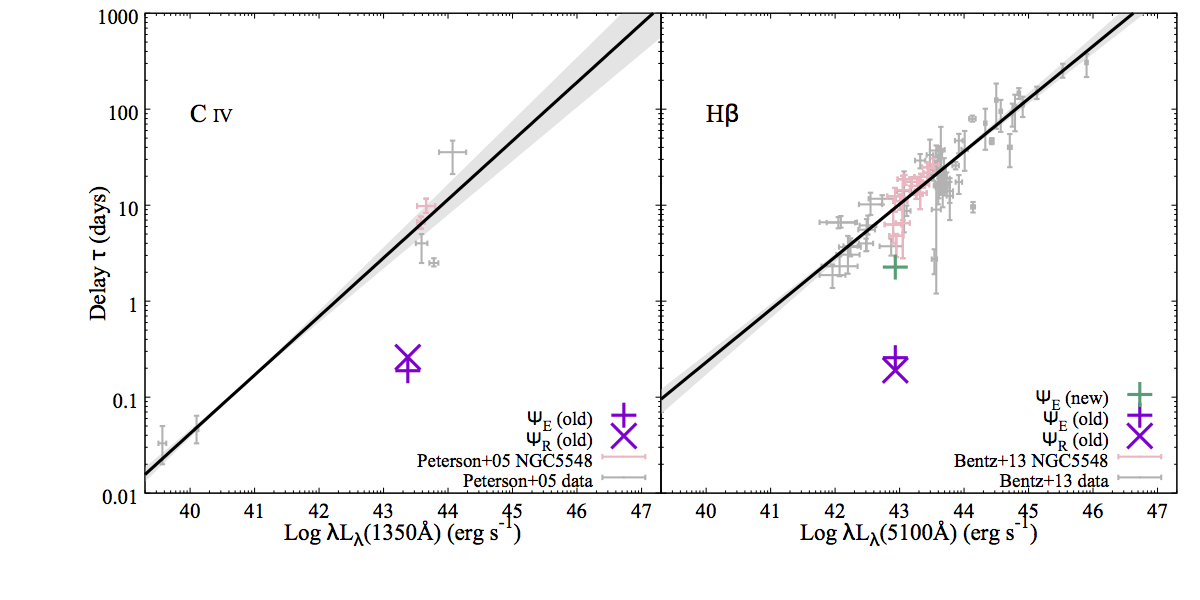

In [17]:
PATH = "/Users/amsys/paper_cloudy/lum_t.png"
Image(filename = PATH, width=800, height=800)

This still looks like we're on the very low end of the range, but it's a dramatic improvement!

I've downloaded some spectra for 5548 from Peterson's library here:


/Users/amsys/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


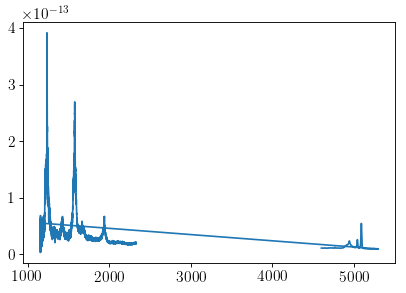

In [42]:
from astropy.io import fits
from astropy import table as apt

spec_obs_opt = Table.read('spectra_JD7517_optical.dat', format='ascii', names=('wave', 'val', 'error'))

fits_uv = fits.open('spectra_JD7517_uv.fits')
spec_obs_uv = fits_uv[0].data

spec_obs_uv = Table.read('spectra_JD49117_uv.lis', format='ascii', names=('wave', 'val', 'error'))
spec_obs = apt.vstack([spec_obs_opt, spec_obs_uv])

fig, ax = plt.subplots()
ax.plot(spec_obs['wave'], spec_obs['val'], '-', label='Observed')
fig.show()

### 14-4-2018 BOTH LINES

I've rerun for both C-IV and Hb:

In [4]:
r10f = 'l100_r10_s-full'

def tf_for_line(db, name, continuum, line, wave, scaling, spectrum=0):
    print('Running '+name)
    tf = tfpy.TransferFunction(db, name, continuum=continuum, wave_bins=100, delay_bins=100)
    tf.spectrum(spectrum).line(line, wave).delay_dynamic_range(2).run(scaling_factor=scaling)
    tf.plot(velocity=True)
    print("Delay: {} days".format(tf.delay(threshold=0.8) * 1.15741e-5))
    print("Delay: {} seconds".format(tf.delay(threshold=0.8)))
    
db = tfpy.open_database(r10f)        
tf_for_line(db, r10f+'_hb', 1.043e44, 28, 6562.8, 1/40, 0)
tf_for_line(db, r10f+'_c4', 1.043e44, 416, 1550, 1/40, 0)

Opening database 'l100_r10_s-full'...
Found existing filled photon database 'l100_r10_s-full'
Running l100_r10_s-full_hb
'l100_r10_s-full_hb' successfully run (34.2s)
Plotting to file 'l100_r10_s-full_hb.eps'...
Total line: 2.958e-04
Successfully plotted (1.8s)
Delay: 2.2508961489291295 days
Delay: 194476.99163901553 seconds
Running l100_r10_s-full_c4


/Users/amsys/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


'l100_r10_s-full_c4' successfully run (55.3s)
Plotting to file 'l100_r10_s-full_c4.eps'...
Total line: 4.692e-04
Successfully plotted (1.7s)
Delay: 2.7488834723 days
Delay: 237503.0 seconds


/Users/amsys/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


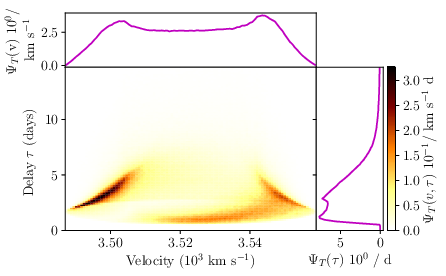

In [6]:
os.system('convert '+r10f+'_hb.eps '+r10f+'_hb.png')
Image(filename = r10f+'_hb.png', width=800, height=800)

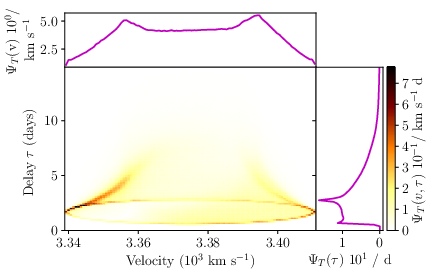

In [7]:
os.system('convert '+r10f+'_c4.eps '+r10f+'_hb.png')
Image(filename = r10f+'_c4.png', width=800, height=800)

We see a pretty dramatic difference in the C4 and Hb emissivity functions, now- the C4 is *much* more limited radius, at a notably higher velocity, and has a bigger difference in delay. The outflow character is basically illegible, though...

Updating our EF delay plot, we get a C-IV delay that is pretty much slap bang in the middle of where we expect. This suggests that actually, we're looking pretty good. The Hb is the only thing, if anything, that needs tweaking... 
![EF_delays](lum_t.png)